# Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf ,plot_predict
from statsmodels.tsa.arima.model import ARIMA
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Cargar y explorar el dataset

In [2]:
# Cargar dataset en un DataFrame
path = "../Data/series (1).csv"
df = pd.read_csv(path)

In [3]:
# Ver forma del df
registros = df.shape[0]
columnas = df.shape[1]
print(f"Registros: {registros}\nColumnas: {columnas}")

Registros: 2686
Columnas: 3


In [4]:
# Observar primeros 3 registros
df.head(3)

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23


In [5]:
# Ver columnas, tipos de datos y si contienen nulos
print(df.isna().any().any())
df.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB


**El df no contiene nulos.**

**Hay 3 columnas, una con categoría de productos de tipo object, otra de fecha de tipo Object, y finalmente las unidades, de tipo Int. La columna "DATE" posteriormente será casteada a time Datetime.**

In [6]:
# Evaluar categorías
df["CATEGORY"].value_counts()

CATEGORY
CATEG-3    920
CATEG-1    887
CATEG-2    879
Name: count, dtype: int64

**El df presenta 3 categorías, con cantidades similares de registros. Para entrenar modelos ARIMA, SARIMA y SARIMAX, el df se dividirá para cada categoría.**

In [7]:
# Evaluar columna "DATE"
df["DATE"].nunique()

921

**La columna "DATE" contiene 921 fechas únicas.**

In [8]:
print(f"Fecha mínima: {df["DATE"].min()}\nFecha máxima: {df["DATE"].max()}")

Fecha mínima: 2018-09-24
Fecha máxima: 2021-11-12


In [9]:
# Convertir columna "DATE" en tipo Datetime
df["DATE"] = pd.to_datetime(df["DATE"])
df["DATE"].dtype

dtype('<M8[ns]')

In [10]:
# Evaluar columna "UNITS_SOLD"
df["UNITS_SOLD"].value_counts()[:5]

UNITS_SOLD
3     46
4     45
18    38
11    36
1     33
Name: count, dtype: int64

In [11]:
df["UNITS_SOLD"].nunique()

915

In [12]:
# Evaluar estadísticas descriptivas
df["UNITS_SOLD"].describe()

count    2686.000000
mean      531.340283
std       840.944458
min         0.000000
25%        25.000000
50%        62.000000
75%       695.000000
max      7551.000000
Name: UNITS_SOLD, dtype: float64

**El rango de la cantidad de unidades vendidas va de 0 a 7551, con una mediana de 62 y una media de aproximadamente 531, indicando la presencia de outliers.**

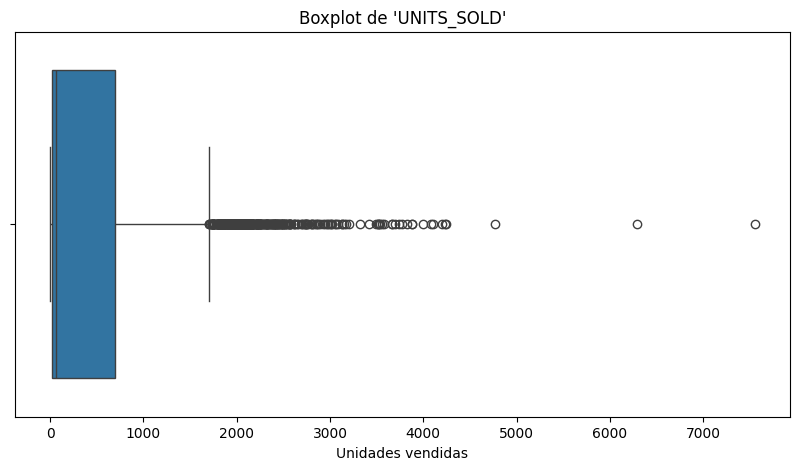

In [13]:
# Graficar
plt.figure(figsize=(10,5))
plt.title("Boxplot de 'UNITS_SOLD'")
plt.xlabel("Unidades vendidas")
sns.boxplot(x=df["UNITS_SOLD"]);

In [14]:
# Agrupar por categoría y evaluar unidades vendidas
ventas_por_cat = df.groupby("CATEGORY")["UNITS_SOLD"].sum().sort_values(ascending=False)
ventas_por_cat

CATEGORY
CATEG-3    1340720
CATEG-1      47127
CATEG-2      39333
Name: UNITS_SOLD, dtype: int64

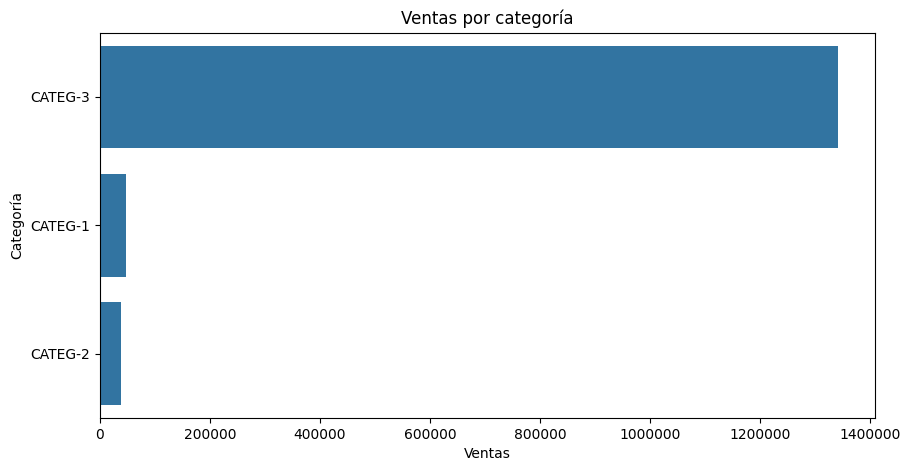

In [15]:
# Graficar ventas por categoría
plt.figure(figsize=(10,5))
plt.title("Ventas por categoría")
plt.ylabel("Categoría")
plt.xlabel("Ventas")
plt.ticklabel_format(style='plain', axis='x')
sns.barplot(y=ventas_por_cat.index, x=ventas_por_cat.values);

In [16]:
# Calcular diferencia de ventas entre la primera y segunda categoría con mayor cantidad de ventas
dif_ventas_por_cat = ventas_por_cat.loc["CATEG-3"] - ventas_por_cat.loc["CATEG-1"]
dif_ventas_por_cat

1293593

**Se puede observar que la categoría "CATEG-3" es la que mayor unidades vendidas presenta, seguidas de lejos por la 1 y la 2, con una diferencia de 1293593 unidades vendidas entre la "CATEG-3" y la "CATEG-1".**

# Preprocesamiento para ARIMA, SARIMA y SARIMAX

**Para trabajar con los modelos ARIMA, es necesario dividir el dataset por cada categoría. Esto es necesario porque el modelo se basa en el comportamiento histórico de cada categoría, y cada una puede tener patrones únicos. Los modelos agregados mezclarían los patrones y podrían empeorar el forecasting.**

**Esta división permitiría estimar las ventas de los siguientes 21 días, para cada una de las categorías.**

In [17]:
# Crear 3 df filtrados por cada categoría y crear copias para no modificar el df original
categ_1 = df[df["CATEGORY"] == "CATEG-1"].copy()
categ_2 = df[df["CATEGORY"] == "CATEG-2"].copy()
categ_3 = df[df["CATEGORY"] == "CATEG-3"].copy()

# Verificar
print(categ_1.head(1))
print(categ_2.head(1))
print(categ_3.head(1))

  CATEGORY       DATE  UNITS_SOLD
0  CATEG-1 2021-08-17          59
  CATEGORY       DATE  UNITS_SOLD
2  CATEG-2 2021-10-26          23
  CATEGORY       DATE  UNITS_SOLD
5  CATEG-3 2018-10-18           1


In [18]:
# Ordenar dfs por fechas
categ_1 = categ_1.sort_values(by=["DATE"])
categ_2 = categ_2.sort_values(by=["DATE"])
categ_3 = categ_3.sort_values(by=["DATE"])

# Verificar
categ_1["DATE"].head(3)

1526   2018-10-16
506    2019-06-11
1539   2019-06-12
Name: DATE, dtype: datetime64[ns]

**Evaluar secuencialidad de fechas, porque los modelos ARIMA, SARIMA y SARIMAX requieren fechas consecutivas.**

In [19]:
categ_1.head()

,CATEGORY,DATE,UNITS_SOLD
1526,CATEG-1,2018-10-16,1
506,CATEG-1,2019-06-11,27
1539,CATEG-1,2019-06-12,26
423,CATEG-1,2019-06-13,24
2222,CATEG-1,2019-06-14,18


In [20]:
categ_2.head()

,CATEGORY,DATE,UNITS_SOLD
59,CATEG-2,2018-10-16,1
2369,CATEG-2,2019-06-11,15
1503,CATEG-2,2019-06-12,13
92,CATEG-2,2019-06-13,8
814,CATEG-2,2019-06-14,9


In [21]:
categ_3.head()

,CATEGORY,DATE,UNITS_SOLD
1818,CATEG-3,2018-09-24,0
2136,CATEG-3,2018-09-25,0
1803,CATEG-3,2018-09-27,0
669,CATEG-3,2018-09-28,2
2617,CATEG-3,2018-09-29,1


**Se puede observar que por lo menos en los df de "CATEG-1" y "CATEG-2", hay 1 salto de fechas.**

**Es necesario entender si es un comportamiento que solo sucede con el primer registro, en ese caso se podría evaluar eliminarlo, ya que solo tiene una venta y un salto significativo, o si es una situación frecuente, y en ese caso se podría rellenar con 0 ventas las fechas faltantes, para representar la falta de ventas, para generar una continuidad en las fechas y que los modelos funcionen correctamente.**

In [22]:
# Función para evaluar fechas no consecutivas
def fechas_no_consecutivas(df_cat, col="DATE"):
    """Función que devuelve un df con fechas que no sean consecutivas con las otras fechas de la columna"""
    # Crear nuevo df para testear
    df_test = df_cat.copy()
    
    # Calcular diferencias hacia adelante y hacia atrás
    dif_anterior = df_test[col].diff(periods=1)  
    dif_posterior = df_test[col].diff(periods=-1)

    # Filtrar donde la diferencia no sea de 1 día
    fechas_no_continuas = (dif_anterior != pd.Timedelta(days=1)) & (dif_anterior.notna()) | \
                          (dif_posterior != pd.Timedelta(days=-1)) & (dif_posterior.notna())

    # Devolver las fechas no consecutivas y sus índices
    return df_test[fechas_no_continuas], df_cat[fechas_no_continuas].index

In [23]:
# Evaluar fechas no consecutivas para categ_1
categ_1_fechas_no_consecutivas, categ_1_idx_a_arreglar = fechas_no_consecutivas(categ_1)
print(categ_1_idx_a_arreglar)
categ_1_fechas_date = categ_1_fechas_no_consecutivas["DATE"]
categ_1_fechas_no_consecutivas

Index([1526, 506], dtype='int64')


,CATEGORY,DATE,UNITS_SOLD
1526,CATEG-1,2018-10-16,1
506,CATEG-1,2019-06-11,27


In [24]:
# Evaluar fechas no consecutivas para categ_2
categ_2_fechas_no_consecutivas, categ_2_idx_a_arreglar = fechas_no_consecutivas(categ_2)
print(categ_2_idx_a_arreglar)
categ_2_fechas_date = categ_2_fechas_no_consecutivas["DATE"]
categ_2_fechas_no_consecutivas

Index([59, 2369, 1484, 304, 90, 1043], dtype='int64')


,CATEGORY,DATE,UNITS_SOLD
59,CATEG-2,2018-10-16,1
2369,CATEG-2,2019-06-11,15
1484,CATEG-2,2019-08-13,10
304,CATEG-2,2019-08-21,8
90,CATEG-2,2019-10-25,2
1043,CATEG-2,2019-10-27,2


In [25]:
# Evaluar fechas no consecutivas para categ_3
categ_3_fechas_no_consecutivas, categ_3_idx_a_arreglar = fechas_no_consecutivas(categ_3)
print(categ_3_idx_a_arreglar)
categ_3_fechas_date = categ_3_fechas_no_consecutivas["DATE"]
categ_3_fechas_no_consecutivas

Index([2136, 1803, 406, 5, 2077, 228, 1325, 1204, 665, 1242, 1375], dtype='int64')


,CATEGORY,DATE,UNITS_SOLD
2136,CATEG-3,2018-09-25,0
1803,CATEG-3,2018-09-27,0
406,CATEG-3,2018-10-15,1
5,CATEG-3,2018-10-18,1
2077,CATEG-3,2018-10-25,0
228,CATEG-3,2018-10-29,0
1325,CATEG-3,2018-11-03,0
1204,CATEG-3,2018-11-05,0
665,CATEG-3,2018-11-08,0
1242,CATEG-3,2018-11-11,0


**En categ_1 y categ_2, la primera fecha no consecutiva, "2018-10-16", tiene un salto de aproximadamente 7 meses, por lo tanto, sería relevante eliminar ese primer registro, para no rellenar los días de 7 meses con 0s y afectar al modelo.**

**Las fechas aisladas con saltos poco significativos, presentes en los 3 dfs, serán rellenadas con 0s.**

In [26]:
# Eliminar primer registro de fecha en categ_1 y categ_2
categ_1.drop(index=[categ_1_idx_a_arreglar[0]], inplace=True)
categ_2.drop(index=[categ_2_idx_a_arreglar[0]], inplace=True)

In [27]:
# Eliminar primer índice de las primeras 2 listas
categ_1_idx_a_arreglar = list(categ_1_idx_a_arreglar)
categ_1_idx_a_arreglar.pop(0)

categ_2_idx_a_arreglar = list(categ_2_idx_a_arreglar)
categ_2_idx_a_arreglar.pop(0)

# Verificar
categ_1_idx_a_arreglar

[506]

In [28]:
# Ya que las categorías no son necesarias al haber separado los df, se droppea esa columna
categ_1.drop(columns="CATEGORY", inplace=True)
categ_2.drop(columns="CATEGORY", inplace=True)
categ_3.drop(columns="CATEGORY", inplace=True)

# Verificar
categ_1.columns

Index(['DATE', 'UNITS_SOLD'], dtype='object')

In [29]:
# Función para llenar fechas faltantes con 0s
def llenar_fechas_con_0(df_cat, indices_no_continuos, col_fecha="DATE", col_ventas="UNITS_SOLD"):
    """Función para llenar fechas faltantes con 0s."""
    # Crear una copia para trabajar
    df_filled = df_cat.copy()
    
    # Loopear por los índices de fechas no consecutivas para agregar fechas faltantes inmediatas
    for idx in indices_no_continuos:
        fecha_actual = df_filled.loc[idx, col_fecha]

        # Comprobar y agregar la fecha posterior inmediata si falta
        fecha_posterior = fecha_actual + pd.Timedelta(days=1)
        if fecha_posterior not in df_filled[col_fecha].values:
            df_filled.loc[idx+1000000, col_fecha] = fecha_posterior
            df_filled.loc[idx+1000000, col_ventas] = 0

        # Comprobar y agregar la fecha anterior inmediata si falta
        fecha_anterior = fecha_actual - pd.Timedelta(days=1)
        if fecha_anterior not in df_filled[col_fecha].values:
            df_filled.loc[idx+1000000, col_fecha] = fecha_anterior
            df_filled.loc[idx+1000000, col_ventas] = 0

    return df_filled

In [30]:
# Crear fechas faltantes y llenarlas con 0 ventas
categ_1 = llenar_fechas_con_0(categ_1, categ_1_idx_a_arreglar)

**Verificar de forma manual, debido a un bug en la función. Si bien no es muy pythónico, debido al tiempo disponible, es necesario continuar y luego de finalizar, revisar una mejor solución.**

In [31]:
# Verificar y completar casos
fecha_base_categ_1 = categ_1.loc[categ_1_idx_a_arreglar]["DATE"]
fecha_base_categ_1

506   2019-06-11
Name: DATE, dtype: datetime64[ns]

In [32]:
# Verificar fechas anteriores y posteriores
categ_1[categ_1["DATE"] == "2019-06-10"]

,DATE,UNITS_SOLD
1000506,2019-06-10,0.0


In [33]:
categ_1[categ_1["DATE"] == "2019-06-12"]

,DATE,UNITS_SOLD
1539,2019-06-12,26.0


In [35]:
# Crear fechas faltantes y llenarlas con 0 ventas para categ_2
categ_2 = llenar_fechas_con_0(categ_2, categ_2_idx_a_arreglar)

In [43]:
# Revisar en categ_2
categ_2_fechas_date

59     2018-10-16
2369   2019-06-11
1484   2019-08-13
304    2019-08-21
90     2019-10-25
1043   2019-10-27
Name: DATE, dtype: datetime64[ns]

In [37]:
categ_2[categ_2["DATE"] == "2019-06-11"]

,DATE,UNITS_SOLD
2369,2019-06-11,15.0


In [38]:
categ_2[categ_2["DATE"] == "2019-06-10"]

,DATE,UNITS_SOLD
1002369,2019-06-10,0.0


In [39]:
categ_2[categ_2["DATE"] == "2019-06-12"]

,DATE,UNITS_SOLD
1503,2019-06-12,13.0


In [44]:
# Crear fechas faltantes y llenarlas con 0 ventas para categ_3
categ_3 = llenar_fechas_con_0(categ_3, categ_3_idx_a_arreglar)

In [45]:
# Revisar en categ_3
categ_3_fechas_date

2136   2018-09-25
1803   2018-09-27
406    2018-10-15
5      2018-10-18
2077   2018-10-25
228    2018-10-29
1325   2018-11-03
1204   2018-11-05
665    2018-11-08
1242   2018-11-11
1375   2019-06-11
Name: DATE, dtype: datetime64[ns]

In [47]:
categ_3[categ_3["DATE"] == "2018-09-27"]

,DATE,UNITS_SOLD
1803,2018-09-27,0.0


In [48]:
categ_3[categ_3["DATE"] == "2018-09-26"]

,DATE,UNITS_SOLD
1002136,2018-09-26,0.0


In [49]:
categ_3[categ_3["DATE"] == "2018-09-28"]

,DATE,UNITS_SOLD
669,2018-09-28,2.0


**Para trabajar con series de tiempo, es necesario crear un índice con la columna "DATE".**

In [45]:
categ_1.index = pd.PeriodIndex(categ_1["DATE"], freq="M")

,CATEGORY,DATE,UNITS_SOLD
1526,CATEG-1,2018-10-16,1
506,CATEG-1,2019-06-11,27
1539,CATEG-1,2019-06-12,26
423,CATEG-1,2019-06-13,24
2222,CATEG-1,2019-06-14,18
...,...,...,...
1723,CATEG-1,2021-11-08,63
717,CATEG-1,2021-11-09,65
2605,CATEG-1,2021-11-10,189
736,CATEG-1,2021-11-11,194


In [47]:
# EVALUAR FECHAS! CoMPLETAR CON 0s en fechas faltantes, para indicar que esas fechas no tienen ventas en esas unidades
# ES NECESARIO PARA QUE FUNCIONE EL MODELO ARIMA CORRECTAMENTE!

In [ ]:
# PARA ARIMA, SERIE ESTACIONARIA, ELIMINAR TENDENCIA Y ESTACIONALIDAD

In [ ]:
# PARA SARIMA, ELIMINAR TENDENCIA

In [48]:
# PARA SARIMAX, ELIMINAR TENDENCIA y AGREGAR CATEGORIA COMO VARIABLE EXOGENA!

# Modelos de Machine Learning